In [1]:
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: right;
    vertical-align: middle;
}
</style>
""")

# system ----
import os
import sys
import matplotlib
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerBase

import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
 
# !!! you will have to edit this to your local computer

# local ----
localPath = os.path.expanduser("~/")
projPath = os.path.expanduser(localPath+"_projects/researchproject_014/")
sys.path.append(projPath+"modules")
import plot_parameters 

# !!! 

---
# Particle Distribution

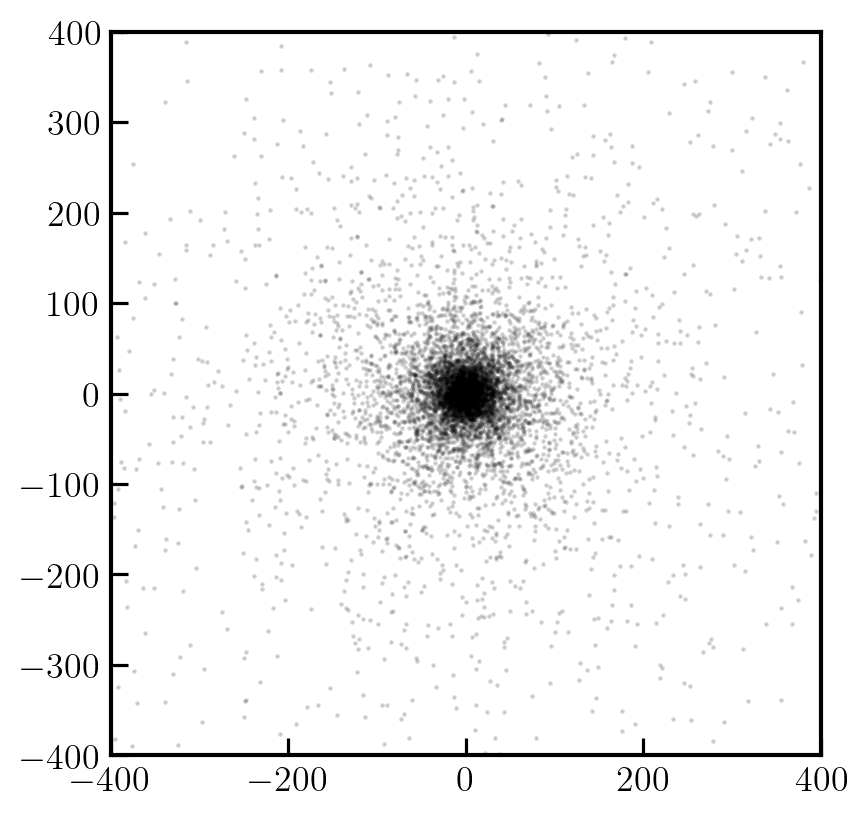

In [16]:
fig, ax = plt.subplots(figsize=(5.5/1.2,5.75/1.2),
                       ncols=1,nrows=1,
                        dpi=100)
plt.subplots_adjust(wspace=None, hspace=0.35)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.set_xscale('linear'); ax.set_yscale('linear')
ax.set_xlim(-400, 400); ax.set_ylim(-400, 400)

# ----------------------------------------------------------------------------

with h5py.File('../results/dehnen_isotropic_n4_m12_rs35_gamma1.50.hdf5', 'r') as h5:
    p0 = h5['PartType1']
    ax.scatter(p0['Coordinates'][:, 0], p0['Coordinates'][:, 1], color='k', s=0.5, alpha=0.15)

# ----------------------------------------------------------------------------

plt.show()

---
# Halo dark matter density profile

In [5]:
G_CONSTANT = 4.3e-6

def compute_mass_profiles(part_sep: float, part_mass: float, nbins_equal: bool = False,
                          log_bounds: float = None, nbins: int = 25,
                          clean_up: bool = True, *args, **kwargs) -> float:
    """Computes the spherically averaged density profiles from halo centered 
       particle positions [(3, N) numpy array] and particle mass
    """
    results = dict()

    # compute magnitude of particle seperation
    part_sep_mag = compute_seperation(part_sep, 0.0)

    # specificy which radial array to use
    if nbins_equal:
        radial_arr = histedges_equal_number(part_sep_mag, nbins)
    else:
        if log_bounds == None:
            power_arr = 0
        elif isinstance(log_bounds, tuple):
            power_arr = np.linspace(log_bounds[0], log_bounds[1], nbins)
        else:
            sys.exit("!!! Either dont put anything here or specify a tuple !!!")
        radial_arr = 10.0 ** power_arr

    # intialize data arrays
    results['radial.bins'] = np.zeros(nbins)
    results['density.bins:local'] = np.zeros(nbins)
    results['number.bins:local'] = np.zeros(nbins)
    results['number.bins:enclosed'] = np.zeros(nbins)
    results['mass.bins:enclosed'] = np.zeros(nbins)
    results['density.bins:enclosed'] = np.zeros(nbins)
    results['circular.velocity.bins'] = np.zeros(nbins)
    
    for ind, rad in enumerate(radial_arr):
        # want to maintain same shape as nbins, so catch first index and set to zero 
        # when taking the averaged centered radius.
        if(ind == 0):
            lower_rad = 0.0
        else:
            lower_rad = radial_arr[ind-1]
        higher_rad = rad

        # center the radial bins
        rad_centered = (lower_rad + higher_rad) / 2.0
        results['radial.bins'][ind] += rad_centered

        # sample particles within spherical shells (and enclosing) radius r 
        rcond1 = lower_rad < part_sep_mag
        rcond2 = part_sep_mag < higher_rad
        rcond3 = part_sep_mag < rad_centered
        part_in_shell = np.where((rcond1) & (rcond2))[0]
        part_enc_rad = np.where(rcond3)[0]

        # compute local profile
        vol_in_shell = (4.0*np.pi/3.0) * (higher_rad**3 - lower_rad**3)
        numb_part_in_shell = part_in_shell.shape[0]
        tot_mass_in_shell = np.sum(part_mass[part_in_shell])
        results['density.bins:local'][ind] += tot_mass_in_shell / vol_in_shell
        results['number.bins:local'][ind] += numb_part_in_shell / vol_in_shell

        # compute enclosed profile
        enclosed_vol = (4.0*np.pi/3.0) * rad_centered**3
        enclosed_numb = part_enc_rad.shape[0]
        enclosed_mass = np.sum(part_mass[part_enc_rad])

        results['number.bins:enclosed'][ind] += enclosed_numb
        results['mass.bins:enclosed'][ind] += enclosed_mass
        results['density.bins:enclosed'][ind] += enclosed_mass / enclosed_vol
        results['circular.velocity.bins'][ind] += np.sqrt(enclosed_mass * G_CONSTANT / rad_centered)

    if clean_up:
        nonzero_dens = (results['density.bins:local'] != 0.0)
        for skey, sval in results.items():
            results[skey] = sval[nonzero_dens]

    return results

# ----------------------------------------------------------------------------

def histedges_equal_number(array, n_partitions: int) -> None:
    """Generates equal bin sizes for desired number of particles"""
    npt = array.shape[0]
    nbins = int(npt/n_partitions)
    return np.interp(np.linspace(0, npt, nbins+1), np.arange(npt), np.sort(array))

# ----------------------------------------------------------------------------

def compute_seperation(pos1: float, pos2: float) -> float:
    """Quick and dirty method for computing position seperation.
       Be very careful with what you are evaluating.
    """
    sep = pos1 - pos2

    if isinstance(pos2, float):
        result = np.sqrt(sep[:, 0]**2 + sep[:, 1]**2 + sep[:, 2]**2)
    elif pos1.shape != pos2.shape:
        result = np.sqrt(sep[:, 0]**2 + sep[:, 1]**2 + sep[:, 2]**2)
    else:
        result = np.sqrt(sep[0]**2 + sep[1]**2 + sep[2]**2)

    return result

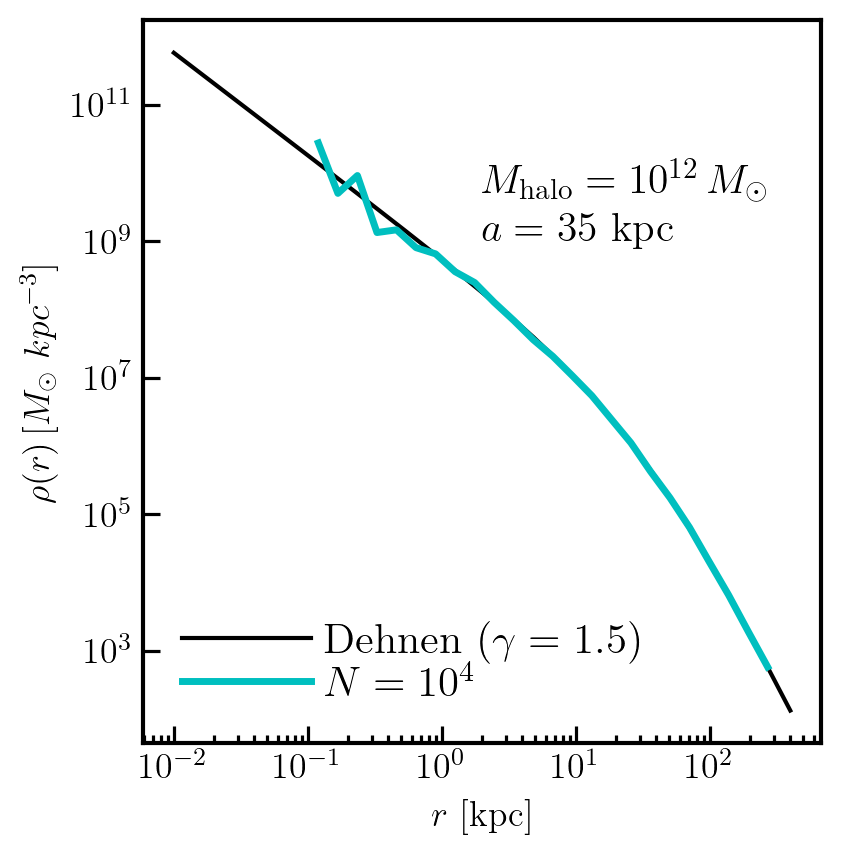

In [20]:
fig, ax = plt.subplots(figsize=(5.25/1.2,5.75/1.2),
                       ncols=1,nrows=1,
                        dpi=100)
plt.subplots_adjust(wspace=None, hspace=0.35)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.set_xlabel(r'$r\ [\rm kpc]$'); ax.set_ylabel(r'$\rho(r)\, [M_{\odot}\ kpc^{-3}]$')
ax.set_xscale('log'); ax.set_yscale('log')
#ax.set_xlim(1,11); ax.set_ylim(0.01,1)

nbins = 25
rad_arr = 10.0 ** np.linspace(-2, np.log10(400), nbins)
rad_arr_ext = 10.0 ** np.linspace(-3, np.log10(500), nbins)

# ----------------------------------------------------------------------------

M = 1e12
a = 35.0
gamma = 1.5
def dehnen_profile(r: float) -> float:
    factor = (3.0 - gamma) * M / 4.0 / np.pi
    return factor * a / r**gamma / np.power(r+a, 4.0-gamma) 

ax.plot(rad_arr, dehnen_profile(rad_arr), color='k', lw=1.5, label=r'$\mathrm{Dehnen}\ (\gamma = 1.5)$')

with h5py.File('../results/dehnen_isotropic_n4_m12_rs35_gamma1.50.hdf5', 'r') as h5:
    p1 = h5['PartType1']
    mass_dense = compute_mass_profiles(part_sep=p1['Coordinates'][()], 
                                       part_mass=p1['Masses'][()], 
                                       log_bounds=(-1, 2.5), 
                                       nbins=nbins,
                                       clean_up=True)
    
    ax.plot(mass_dense['radial.bins'][:], mass_dense['density.bins:local'], ls='-', color='c', lw=2.5, label=r'$N = 10^{4}$')
    
# ----------------------------------------------------------------------------

ax.text(2, 5e9, r'$M_{\rm halo} = 10^{12}\, M_{\odot}$', fontsize=15)
ax.text(2, 1e9, r'$a = 35\ \rm kpc$', fontsize=15)
ax.legend(frameon=False, loc='lower left', fontsize=15.5, handlelength=3, handletextpad=0.3, labelspacing=0.05)

# ----------------------------------------------------------------------------

plt.show()

---

In [22]:
def radial_velocity_dispersion(part_sep: float, part_vel: float,
                              log_bounds: float = None, nbins: int = 25,
                              clean_up: bool = True, *args, **kwargs) -> float:
    results = dict()
    
    # compute magnitude of particle seperation
    rad_vel = radial_velocity(part_sep, part_vel)
    part_sep_mag = compute_seperation(part_sep, 0.0)

    # specificy which radial array to use
    if log_bounds == None:
        power_arr = 0
    elif isinstance(log_bounds, tuple):
        power_arr = np.linspace(log_bounds[0], log_bounds[1], nbins)
    else:
        sys.exit("!!! Either dont put anything here or specify a tuple !!!")
    radial_arr = 10.0 ** power_arr

    # intialize data arrays
    results['radial.bins'] = np.zeros(nbins)
    results['rad.vel.disp'] = np.zeros(nbins)

    for ind, rad in enumerate(radial_arr):
        # want to maintain same shape as nbins, so catch first index and set to zero 
        # when taking the averaged centered radius.
        if(ind == 0):
            lower_rad = 0.0
        else:
            lower_rad = radial_arr[ind-1]
        higher_rad = rad

        # center the radial bins
        rad_centered = (lower_rad + higher_rad) / 2.0
        results['radial.bins'][ind] += rad_centered

        # sample particles within spherical shells (and enclosing) radius r 
        rcond1 = lower_rad < part_sep_mag
        rcond2 = part_sep_mag < higher_rad
        part_in_shell = np.where((rcond1) & (rcond2))[0]
        rvel_in_shell = rad_vel[part_in_shell]

        # compute local profile
        avg_rad_vel = np.average(rvel_in_shell) 
        sq_diff = (rvel_in_shell - avg_rad_vel)**2
        sigma_r_sq = np.sum(sq_diff) / np.float(part_in_shell.shape[0])

        results['rad.vel.disp'][ind] += np.sqrt(sigma_r_sq)
        
    if clean_up:
        nonzero_dens = (results['rad.vel.disp'] != 0.0)
        for skey, sval in results.items():
            results[skey] = sval[nonzero_dens]

    return results

# ----------------------------------------------------------------------------
    
def radial_velocity(pos: float, vel: float) -> float:
    rmag = compute_seperation(pos, 0.0)
    dotprod = pos[:, 0]*vel[:, 0] + pos[:, 1]*vel[:, 1] + pos[:, 2]*vel[:, 2]
    return dotprod / rmag

# ----------------------------------------------------------------------------

def compute_seperation(pos1: float, pos2: float) -> float:
    """Quick and dirty method for computing position seperation.
       Be very careful with what you are evaluating.
    """
    sep = pos1 - pos2

    if isinstance(pos2, float):
        result = np.sqrt(sep[:, 0]**2 + sep[:, 1]**2 + sep[:, 2]**2)
    elif pos1.shape != pos2.shape:
        result = np.sqrt(sep[:, 0]**2 + sep[:, 1]**2 + sep[:, 2]**2)
    else:
        result = np.sqrt(sep[0]**2 + sep[1]**2 + sep[2]**2)

    return result

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/9r/jd9klpcj2dv72j41rwrdmwjh0000gn/T/ipykernel_10328/3793177012.py:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigma_r_sq = np.sum(sq_diff) / np.float(part_in_shell.shape[0])
/var/folders/9r/jd9klpcj2dv72j41rwrdmwjh0000gn/T/ipykernel_10328/3793177012.py:45: RuntimeWarning: invalid value encountered in double_scalars
  sigma_r_sq 

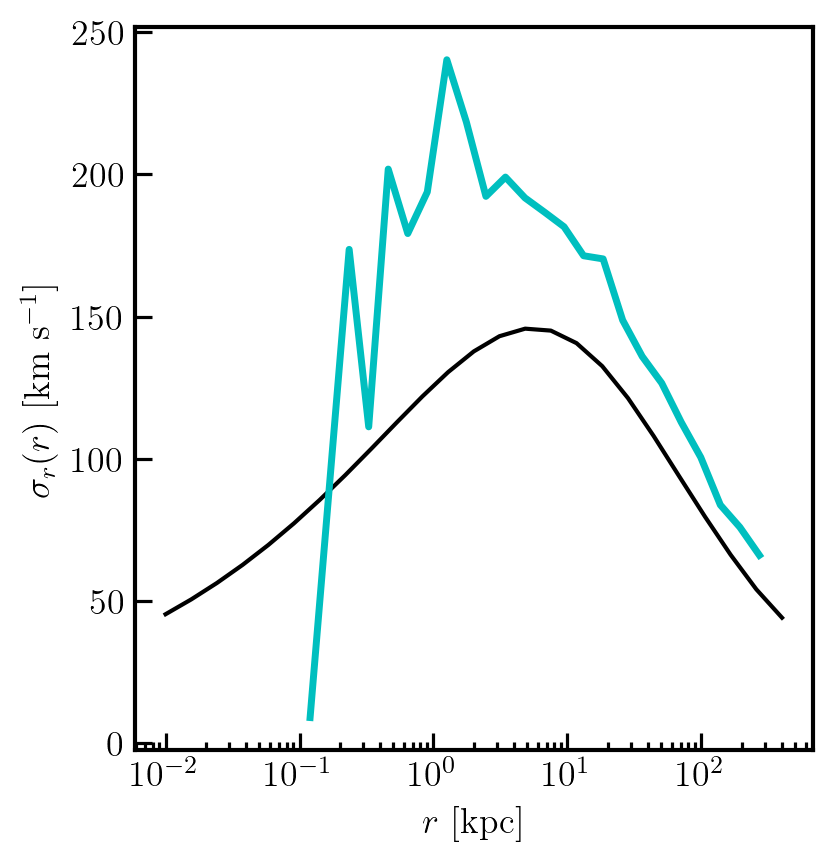

In [25]:
fig, ax = plt.subplots(figsize=(5.25/1.2,5.75/1.2),
                       ncols=1,nrows=1,
                        dpi=100)
plt.subplots_adjust(wspace=None, hspace=0.35)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.set_xlabel(r'$r\ [\rm kpc]$'); ax.set_ylabel(r'$\sigma_{r}(r)\ [\rm km\ s^{-1}]$')
ax.set_xscale('log'); ax.set_yscale('linear')
#ax.set_ylim(50,275)

nbins = 25
rad_arr = 10.0 ** np.linspace(-2, np.log10(400), nbins)
rad_arr_ext = 10.0 ** np.linspace(-3, np.log10(500), nbins)

# ----------------------------------------------------------------------------
from scipy.integrate import quad

G_MSOL = 4.3e-6
M = 1e12 # Msol
a = 35.0
gamma = 1.5

def squared_radial_dispersion(r: float) -> float:
    factor = G_MSOL * M  * r**gamma * np.power(r+a, 4.0-gamma)
    integrand = lambda x: np.power(x, 1.0-2.0*gamma) / np.power(x+a, 7.0-2.0*gamma)
    integral = np.array([quad(integrand, ri, np.infty, limit=100)[0] for ri in r])
    return factor * integral
    
sigma_r = np.sqrt(squared_radial_dispersion(rad_arr))
ax.plot(rad_arr, sigma_r, color='k', lw=1.5, label=r'$\mathrm{Dehnen}\ (\gamma=1.5)$')

# ----------------------------------------------------------------------------

with h5py.File('../results/dehnen_isotropic_n4_m12_rs35_gamma1.50.hdf5', 'r') as h5:
    p1 = h5['PartType1']
    sigma_r = radial_velocity_dispersion(part_sep=p1['Coordinates'][()], 
                                         part_vel=p1['Velocities'][()], 
                                         log_bounds=(-1, 2.5), 
                                         nbins=nbins,
                                         clean_up=True)
    
    ax.plot(sigma_r['radial.bins'][:], sigma_r['rad.vel.disp'], ls='-', color='c', lw=2.5, label=r'$N = 10^{4}$')
    
# ----------------------------------------------------------------------------
    
plt.show()